<a href="https://colab.research.google.com/github/MounaS5/GNN_EHS/blob/master/MutaSarpyPatternMatchAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RDKit Installation and Other Packages


In [ ]:
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO


logger = getLogger(__name__)
logger.addHandler(StreamHandler())
logger.setLevel(INFO)


def install(
        chunk_size=4096,
        file_name="Miniconda3-latest-Linux-x86_64.sh",
        url_base="https://repo.continuum.io/miniconda/",
        conda_path=os.path.expanduser(os.path.join("~", "miniconda")),
        rdkit_version=None,
        add_python_path=True,
        force=False):
    """install rdkit from miniconda
    ```
    import rdkit_installer
    rdkit_installer.install()
    ```
    """

    python_path = os.path.join(
        conda_path,
        "lib",
        "python{0}.{1}".format(*sys.version_info),
        "site-packages",
    )

    if add_python_path and python_path not in sys.path:
        logger.info("add {} to PYTHONPATH".format(python_path))
        sys.path.append(python_path)

    if os.path.isdir(os.path.join(python_path, "rdkit")):
        logger.info("rdkit is already installed")
        if not force:
            return

        logger.info("force re-install")

    url = url_base + file_name
    python_version = "{0}.{1}.{2}".format(*sys.version_info)

    logger.info("python version: {}".format(python_version))

    if os.path.isdir(conda_path):
        logger.warning("remove current miniconda")
        shutil.rmtree(conda_path)
    elif os.path.isfile(conda_path):
        logger.warning("remove {}".format(conda_path))
        os.remove(conda_path)

    logger.info('fetching installer from {}'.format(url))
    res = requests.get(url, stream=True)
    res.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in res.iter_content(chunk_size):
            f.write(chunk)
    logger.info('done')

    logger.info('installing miniconda to {}'.format(conda_path))
    subprocess.check_call(["bash", file_name, "-b", "-p", conda_path])
    logger.info('done')

    logger.info("installing rdkit")
    subprocess.check_call([
        os.path.join(conda_path, "bin", "conda"),
        "install",
        "--yes",
        "-c", "rdkit",
        "python=={}".format(python_version),
        "rdkit" if rdkit_version is None else "rdkit=={}".format(rdkit_version)])
    logger.info("done")

    import rdkit
    logger.info("rdkit-{} installation finished!".format(rdkit.__version__))


if __name__ == "__main__":
    install()

python version: 3.7.11
python version: 3.7.11
remove current miniconda
remove current miniconda
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
done
installing miniconda to /root/miniconda
installing miniconda to /root/miniconda
done
done
installing rdkit
installing rdkit


CalledProcessError: ignored

In [ ]:
sys.path.append('/usr/local/lib/python3.7/site-packages/')

try:
  from rdkit import Chem
  from rdkit.Chem.Draw import IPythonConsole
except ImportError:
  print('Stopping RUNTIME. Colaboratory will restart automatically. Please run cell again.')
  exit()

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import AllChem, MACCSkeys, rdFMCS

from rdkit.Chem import Descriptors,Draw

from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols

Stopping RUNTIME. Colaboratory will restart automatically. Please run cell again.


ModuleNotFoundError: ignored

In [ ]:
# Utilities
import json
from collections import OrderedDict
from tqdm.autonotebook import tqdm

# Scientific python
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from collections import Counter


import re

#Mount Drive


In [ ]:
from google.colab import drive
drive.mount("/content/drive")
!ls #To double check if it has been properly mounted

Mounted at /content/drive
drive  sample_data


#Access Data

In [ ]:
################## TO CALL THE DATASET REQUIRED

def link(db_type,num,lst1):

  #lst1 = ['carcinogenicity','fish_acute_toxicity','mutagenicity','octanol-water_partition']
  car_lst = ['antares/dataset_CARC_ANTARES.txt','caesar/dataset_CARC_CAESAR.txt','iss/dataset_CARC_ISS.txt','isscan-cgx/dataset_CARC_ISSCAN-CGX.txt','Cancer3D_New.xlsx']
  fat_lst = ['epa/dataset_FATHEAD_EPA.txt','knn/dataset_FISH_KNN.txt','nic/dataset_FISH_NIC.txt'] #,'irfmn/dataset_FISH_IRFMN.txt'
  muta_lst = ['SARPY/dataset_MUTA_SARPY.txt','KNN/dataset_MUTA_KNN.txt','ISS/dataset_MUTA_ISS.txt','CAESAR/dataset_MUTA_CAESAR.txt']
  oct_lst = ['mlogp/dataset_LOGP_MLOGP.txt','meylan/dataset_LOGP_MEYLAN.txt','alogp/dataset_LOGP_ALOGP.txt']
  path =''
  if db_type == 0:
    if num in range (0,len(car_lst)):path =  lst1[0] +'/'+car_lst[num]
  elif db_type == 1:
    if num in range (0,len(fat_lst)):path =  lst1[1] +'/'+fat_lst[num]
  elif db_type == 2:
    if num in range (0,len(muta_lst)):path =  lst1[2] +'/'+muta_lst[num]
  elif db_type == 3:
    if num in range (0,len(oct_lst)):path =  lst1[3] +'/'+oct_lst[num]
  else:
    print('Invalid data base type')

  if not path:
    return 'Path is empty'
  else:
    return '/content/drive/My Drive/GNNs/Property_databases/' + path

#, names=('Id','Name','CAS','SMILES', 'Status','Experimental value')
########## STRUCTURING DATA

def restructDB(db_type,num,lst1):
  path = link(db_type,num,lst1)
# Initialise dataframe

  if db_type == 0 and num==4:

    df = pd.read_excel(path)
    df['SMILES'] = df['SMILES'].str.replace(' ','')
    df['SMILES'] = df['SMILES'].str.replace('\n','')
    df['mol'] = df.iloc[1:]['SMILES'].apply(Chem.MolFromSmiles)
    df = df[~df['mol'].isna()]
  else:
    df = pd.read_table(path, names=('Id','CAS','SMILES', 'Status','Experimental value', 'Predicted value'))
  # Fill 'mol' column with 'smiles' to 'mol' dat
    df['mol'] = df.iloc[1:]['SMILES'].apply(Chem.MolFromSmiles)
              
  # Remove 'None' values present in the data
  df1 = df.mask(df.astype(object).eq('None')).dropna()
  df1 = df1.reset_index(drop=True) 
  df1['Id'] = [i for i in df1.axes[0]]
      
  # Fill 'Molecular Weight' column. Might come in use during molecular weight splits.
  mol_wt = 'Molecular Weight'
  df1[mol_wt] = df1.iloc[0:]['mol'].apply(Descriptors.MolWt)

  return df1


In [ ]:
def generateIndices(df,Status):

  idx_data = np.where(df['Status']==Status)
  # Unravel the tuple
  d_list = [ a for (a)  in idx_data] # List with array
  # Convert to list
  idx_list = list(d_list[0])

  new_df = df.loc[df.index.isin(idx_list)]
  y_data = new_df['Experimental value'].values.reshape(-1,1)

  return idx_list,new_df,y_data

In [ ]:
''' 
restructDB ( a , b , c )

a  = index of list 'ehsProp' [0-3]
b  = type of data base [0-3,0-3,0-3,0-2]
c  = ehs property list

'''

ehsProp = ['carcinogenicity','fish_acute_toxicity','mutagenicity','octanol-water_partition']
#[0,1]#carc,[2,0]#muta_sarpy,[1,0],[1,2]
df = restructDB(0,0,ehsProp)
#df['Predicted value'] = df['Predicted value'].fillna(0)
df.head(5)


Status = ['Training','Test']
train_idx,train_df,y_train = generateIndices(df,Status[0])
test_idx,test_df,y_test = generateIndices(df,Status[1])

#print(link(3,1,ehsProp))
print((df[df['Experimental value']==1]).count()[0]) 
print((df[df['Experimental value']==0]).count()[0])  #816
print(len(df.index))

print('********************')


print('Train total points : ', len(train_idx))
print('Test points        : ', len(test_idx))

#Carcinogenicity Indicators


In [ ]:
raw_string_car = ["SA 1: CN[N+]=O SA 2: NNC=O SA 3:CN(C=O)N=O SA 4: CCCCCCN(C)N=O SA 5:",
"CCCN(CCC)N=O SA 6: CNCCNN=O SA 7: CNCCN(C)N=O SA 8: CCNN=O SA 9:",
"CCCCCN(C)N=O SA 10: CCCCN(C)N=O SA 11: CC(O)CNN=O SA 12: CN(N=O)C(=O)NCCO SA 13:", 
"NC(=O)N(CCO)N=O SA 14: CN(N=O)C(N)=O SA 15: CCCNN=O SA 16: O(c1ccccc1)c2ccccc2 SA 17:",
"COc1cccc(O)c1 SA 18: CCc1ccc(OC)cc1O SA 19: CCCNCNN=O SA 20: CCOC(=O)C(C)(C)O SA 21:",
"CC(C)(O)C(O)=O SA 22: Cc1ccccc1-c2ccc(N)cc2 SA 23: Nc1ccc(cc1)-c2ccc(N)cc2 SA 24:",
"Nc1ccc(cc1)-c2ccccc2 SA 25: Nc1ccc(C=C)cc1 SA 26: Nc1cccc(c1)-c2ccccc2 SA 27:",#4 after 25
"Cc1ccc(N)c(C)c1 SA 28: Cc1ccccc1N SA 29: Nc1ccc(Cc2ccc(N)cc2)cc1 SA 30: CN(C)c1ccc(Cc2ccccc2)cc1 SA 31:", 
"Cc1ccc(N)cc1 SA 32: Cc1ccc(NO)cc1 SA 33: Cc1cccc(N)c1 SA 34: CNc1ccc(C=C)cc1 SA 35: Nc1ccc2ccccc2c1 SA 36:",
"CNc1ccc(N)cc1 SA 37: Nc1ccccc1O SA 38: COc1ccccc1N SA 39: Oc1cccc2ccccc12 SA 40: Nc1ccc(O)c(N)c1 SA 41:",
"CC(C)C(C)(O)CO SA 42: Nc1cccc(c1)S(O)(=O)=O SA 43: Cc1cccc2ccccc12 SA 44: NNCO SA 45: CN(N)CO SA 46:",
"CC(O)CNN SA 47: NNCCO SA 48: NNc1ccccc1 SA 49: NNCC=C SA 50: CCNN SA 51: CCCNN SA 52: CC(=O)NN SA 53:",
"CCCN(N)CCC SA 54: CCCN(C)N SA 55: NN SA 56: ClCCCl SA 57: CCl SA 58: CCBr SA 59: CBr SA 60:"
"c1ccc2cc3c(ccc4ccccc34)cc2c1 SA 61: c1ccc-2c(c1)-c3cccc4cccc-2c34 SA 62: CN=O SA 63: N=O SA 64:"
"NO SA 65: Oc1cccc(c1)-c2cccc(O)c2 SA 66: OS(O)(=O)=O SA 67: COS(O)=O SA 68: COS(=O)=O SA 69:"
"ClC1CCCC(Cl)C1Cl SA 70: CC(Cl)CCCCCl SA 71: c1ccc(cc1)N=Nc2ccccc2 SA 72: CCNCCCl 5 SA 73:"
"ClCCNCCCl SA 74: Cc1ccncn1 SA 75: c1cncnc1 SA 76: CC(=C)C(O)=O SA 77: CC=C(C)CO SA 78: CC(C)=NO SA 79:"
"CC(C)=N SA 80: Cn1cncn1 SA 81: c1ncnn1 SA 82: COc1ccc(CC=C)cc1 SA 83: Nc1ncc2ncn(CCCCO)c2n1 SA 84:"
"OCC1OC(CC1O)n2cnc3cncnc23 SA 85: CC1CCC=C(C)C1 SA 86: C1C=CCC=C1 SA 87: O=C(OCc1ccccc1)c2ccccc2 SA 88:"
"CCOCc1ccccc1C SA 89: C(=Cc1ccccc1)c2ccccc2 SA 90: [O-][N+](=O)c1ccco1 SA 91: CCNCC(C)=O SA 92: N=[N+] SA 93:"
"Cc1ccc(cc1)S(O)(=O)=O SA 94: O=C1c2ccccc2C(=O)c3ccccc13 SA 95: Cc1cccnc1 SA 96: CCCCC(O)CCCCC(O)CCC SA 97:"
"Clc1cccc(Cl)c1Cl SA 98: COP=O SA 99: CC(CN)c1ccccc1 SA 100: OCC#C SA 101: NNCc1ccccc1 SA 102:"
"C1CCc2ccccc2C1 SA 103: c1ccsc1 SA 104:Nc1ccccn1 SA 105: C1CO1 SA 106: CC(O)CCCC=O SA 107: C[S]=O SA 108:"
"c1cscn1 SA 109: CC1COCO1 SA 110: Nc1ccc([S]c2ccccc2)cc1 SA 111: Cc1ccc(cc1)C(N)=O SA 112: CN(C)P(N(C)C)N(C)C SA 113:"
"[N+]c1cncn1 SA 114: O=C1CCO1 SA 115: OCCNCC=C SA 116: CCNCCCC(C)C SA 117: c1ccoc1 SA 118: CCOC(N)=O SA 119:"
"C=CCCCCC=O6 SA 120: C1CN1 SA 121: c1cc2ccccc2s1 SA 122: Cc1ncc[nH]1 SA 123: [O-][N+](=O)c1ccc(o1)-c2cscn2 SA 124:"
"C#C SA 125: CCF SA 126: CN=[N+] SA 127: CCCN=CN"]

def str_corr_list(raw_str_m,pattern):
  raw_str = ' '.join(raw_str_m)
  splt_str = raw_str.split(pattern)[1::]

  # Remove numbers
  match = [re.match(r"([0-9]+)", i, re.I) for i in splt_str]
  items = [mat.groups() for mat in match if match]
  
  new_lst = []
  for i,strn in zip(items,splt_str):
    a = strn.replace(i[0], "")
    b = a.replace(": ", "")
    c = b.replace(" ", "")
    new_lst.append(c)
 
  return new_lst
Car_lst = str_corr_list(raw_string_car,'SA ')
print(Car_lst)
def canonicalS(lst):
  c_smiles = []
  non_c_Smiles = []
  for ds in lst:
    try:
        cs = Chem.CanonSmiles(ds)
        c_smiles.append(cs)
    except:
        #print('Invalid SMILES:', ds)
        non_c_Smiles.append(ds)
        
  return c_smiles,non_c_Smiles

#c_smiles,non_c_Smiles = canonicalS(Car_lst_n)

def checkIfDuplicates_1(listOfElems):
    ''' Check if given list contains any duplicates '''
    if len(listOfElems) == len(set(listOfElems)):
        return False
    else:
        return True

checkIfDuplicates_1(c_smiles)
checkIfDuplicates_1(non_c_Smiles)

In [ ]:
Car_lst_n = [s.replace(':', '') for s in Car_lst]

In [ ]:
raw_str = ' '.join(raw_string_car)
splt_str = raw_str.split(pattern)[1::]

# Remove numbers
match = [re.match(r"([0-9]+)", i, re.I) for i in splt_str]
items = [mat.groups() for mat in match if match]

new_lst = []
for i,strn in zip(items,splt_str):
  a = strn.replace(i[0], "")
  b = a.replace(": ", "")
  c = b.replace(" ", "")
  new_lst.append(c)

#Mutagenicity Indicators

In [ ]:
raw_str_muta = ["SM 1: O=[N+]([O-])c1ccc2ccccc2c1 SM 2: O=NN(C)C SM 3: n1ccc(N)c2ccc(cc12) SM 4: c1oc(cc1)[N+](=O)[O-] SM 5:",
"O=[N+]([O-])c1ccc(c2ccccc2)c(c1) SM 6: Nc4ccc(N)cc4N SM 7:",
"C1C=Cc2ccccc2C1 SM 8: N1CC1 SM 9: c1cc([N+](=O)[O-])sc1 SM 10:",
"n1ccnc2c1ccc(N)c2 SM 11: c1ccc2c(c1)cc3ccc(cc3c2)C SM 12: Nc1c(ncn1) SM 13:",
"n1cc(nc2ccc3c(ncn3C)c12) SM 14: O(c1ccccc1)CC2OC2 SM 15: O=C1c2ccccc2C(=O)c3c(O)ccc(O)c13 SM 16: N(O)c1ccc(C=C)cc1 SM 17:",
"c1ccc2ccc3ccc(cc3c2c1)N SM 18: O(Cc1cccc2ccccc12)C SM 19:",
"O=C(c1ccc(cc1)NO) SM 20: O=C(c1ccccc1)Cl SM 21: C1=Cc2cccc3cccc1c23 SM 22:",
"O1CC1CCc2ccc(cc2) SM 23: C(O)C=CCl SM 24: OCC(CBr) SM 25: [N-]=[N+] SM 26:",
"n1c2ccc(cc2c(cc1))C SM 27: O=CC1(OC1)C SM 28: n1cccc2c1ccc3c2ncn3 SM 29:",
"c2nc3C(=O)C=CC(=O)c3cc2 SM 30: O=Nc1ccc(OC)cc1 SM 31: SC(=CCl)Cl SM 32:",
"O=C1c2cccc(N)c2C(=O)c3ccccc13 SM 33: Nc1ccc2c(c1)c3ccccc3n2 SM 34:",
"Oc1ccc2ccc3ccc(cc3c2c1) SM 35: C(c1ccccc1)COC=C SM 36:",
"c1cc2cccc3c4cc(ccc4c(c1)c23) SM 37: N(O)c1ccc(Oc2ccccc2)cc1 SM 38:",
"c1ccc2c(c1)c3ccccc3n2 SM 39: O(Cc1cccc2ccccc12) SM 40:",
"c1ccc2c3ccccc3CCc2c1 SM 41: n1cc2ccccc2s1 SM 42: P(=O)(N)N(C)CC SM 43:",
"C(N)Cl SM 44: c1ccc(C=Cc2ccc(N)cc2)cc1 SM 45: c1cc(ccc1NCCCl) SM 46:",
"N(c1ccc(N=Nc2ccccc2)cc1)C SM 47: O=C(NCc1ccccc1)C SM 48:",
"c1cc2ccc3cccc4ccc(c1)c2c34 SM 49: Nc1cccc(c1)c2ccccc2 SM 50:",
"O=[N+]([O-])c1cccc2cccc(c12) SM 51: O=C(Nc1ccc(cc1)c2ccccc2) SM 52:",
"O=Cc1cccc(c1)[N+] SM 53: O=[N+]([O-])c1cc(N)c(c(N)c1) SM 54:",
"c1ccc(Oc2ccc(N)cc2)cc1 SM 55: COC=CC=CC SM 56: N(=N)NC SM 57:",
"ONc1ccc(cc1)S SM 58: O1CC1Cc2ccc(cc2) SM 59: O=C(c1ccccc1O)c2ccccc2 SM 60:", 
"Nc1ccc(cc1)c2ccccc2 SM 61: c1ccc2c(c1)ccc3c2cc4ccccc4c3 SM 62:",
"c1ccc2c(c1)cc3ccc(cc3c2C) SM 63: c1ccc2c(ccc3c4ccccc4ccc23)c1 SM 64:",
"c1c2ccccc2nc3ccccc13 SM 65: O=CC=C(C(=O)c1ccccc1) SM 66: n1cc(cc2c1ncn2) SM 67:",
"Nc1nccn1C SM 68: C1C(C=C(C))C1(C)C SM 69: Nc1ccc(cc1)[N+](=O)[O-] SM 70:", 
"Nc1ccc(cc1N) SM 71: N=CC=C SM 72: O=[N+]([O-])c1ccc(cc1)CO SM 73:",
"CCNCCCl SM 74: O=S(=O)(OCC) SM 75: c1ccc2c3ccccc3Cc2c1 SM 76:",
"c1c2ccccc2n(c1)C SM 77: C(CBr)Br SM 78: Nc1ccccc1F SM 79:",
"c1ccc(N)c(c1N)C SM 80: c1ccc2c(c1)ccc3cc(ccc23) SM 81:",
"c1ccc2c(c1)cc3ccccc3c2 SM 82: c1ccc2ccccc2c1C SM 83:",
"Nc1ccc(cc1)Cc2ccccc2 SM 84: Oc1ccc2Cc3ccccc3Oc2c1 SM 85: C(Cl)(Cl)Cl SM 86:",
"O(c1ccccc1N)C SM 87: NN(c1ccccc1) SM 88: n1c(N)n(c2ccccc12) SM 89:",
"O=C(N(O))C SM 90: n1ccnc2c1cccc2 SM 91: c1cc(c(N)cc1N)C SM 92:",
"OCC1OC1 SM 93: C(C)Br SM 94: C(OCC)N SM 95: Nc1cccc(N)c1 SM 96: c1c(nn(c1)) SM 97:", 
"C1OC1 SM 98: C(O)N SM 99: c1ccc2cccnc2c1 SM 100: N=NC SM 101:",
"O=CC(=C)Cl SM 102: n1cnc2c(ncn2)c1N SM 103: NNCC SM 104: Cc2ccc(N)cc2 SM 105:", 
"Nc1ccc(N)cc1 SM 106: CCCl SM 107: C=NN1N=Nc2c([nH]c3ccccc23)C1=O SM 108:", 
"NC([N+]) SM 109: n1c2ccc(cc2[s+]c3cc(N)c(cc13))N SM 110:",
"O=Nn1cc(c2ccccc12)CC SM 111: O=CC(=CC)C=CC SM 112: O=C1OCC"]

raw_str_nonmuta = ["SM 113: C(O)CCCCCCCC=CCC SM 114: CCOc1ccc(Cl)cc1 SM 115:",
"C(NC(C(=O))C)C(NC) SM 116: c1(c(ccc(c1)CCCCCC))O SM 117:",
"c1c(c(C(C)(C)C)cc(c1)C) SM 118: c1(c(C(=O)O)cccc1)C(=O) SM 119:",
"S(=O)(=O)(N)c1ccc(N)cc1 SM 120: n1c(nc(nc1)) SM 121: C(=O)(C(CCC(=O)O))O SM 122:",
"CCOCCOCCOCCO SM 123: CC(=O)OCC(CC)CCCC SM 124: P(O)OCCCCC SM 125:", 
"N(c1ccccc1)CCCNC SM 126: c1(C(=O)OC)c(N)cccc1 SM 127:",
"C(C)(Oc1ccccc1)(C)C SM 128: N(CCO)(CCCC)C SM 129: C(=C)CCCl SM 130:",
"C(=O)(C(=C)C)OCCCCC SM 131: Oc1ccc2C=C(COc2c1)c3ccccc3 SM 132:",
"c1(nc2c(o1)cccc2)c3ccccc3 SM 133: c1(c(c(cc(c1)))O)c2c(c(cc(c2)))O SM 134:",
"n1c(cc(c2c1cccc2))CO SM 135: c1c(c(ccc1C(O)CNC)O) SM 136:",
"O(C(=O))C(=O) SM 137: C(=O)(CCC(=O)O) SM 138: S(=O)(=O)(c1ccccc1)N SM 139:", 
"c1c(c(cc(c1Cl)Cl)Cl) SM 140: C(C=C)(CCC=C) SM 141: c1(CCCCCC)ccccc1 SM 142:", 
"N(C)(CCCC)CCCC SM 143: C(=O)(O)CCCCCCCC SM 144:",
"C(=O)(N(c1ccccc1))N SM 145: C1(C(CCC(C1)C)C)O SM 146: c1(C(=O)OCC)ccccc1 SM 147:", 
"c1c(C(F)(F)F)cccc1 SM 148: C(=O)CS SM 149:",
"O(c1ccccc1)CC(CNC(C))O SM 150: C(F)(F)C SM 151: c1cc(c(c(c1)Br)O) SM 152:", 
"c1(Br)ccc(cc1)C SM 153: SCCCC SM 154: C(=O)CC(=O)C SM 155:",
"N(CCO)(CCO)C SM 156: C(=O)N(C)CCC SM 157: CCCCCCCCCCCC SM 158:",
"c1(c(ccc(c1)C=CC)O) SM 159: c1cc(c(cc1)Cl)Cl SM 160: C=CC=C(CCC)C SM 161:", 
"c1ccc(NC(C)C)cc1 SM 162: C1CC(CC(C1))(C)C SM 163: CCCCCCC SM 164:",
"C(C(OC)(C)C) SM 165: N#CCC SM 166: C(=C(CC)O) SM 167: CN1CN=CC=C1 SM 168:",
"S(=O)(=O)c1ccc(N)cc1 SM 169: CC(CC)CCC SM 170: C(=O)(c1ccccc1)OC SM 171:", 
"c1(F)ccc(cc1)C SM 172: C(=Cc1ccccc1)C(=O)c2ccccc2 SM 173:",
"[nH]1cc(c2c1cccc2)CC SM 174: P(=S)(OCC)OC SM 175: [N+](C)(C)C SM 176:",
"OCCN(C)C SM 177: C(=O)CCCCC SM 178: C(=O)(CC(C))OCC SM 179: CC#N SM 180:",
"C(=C(CC)C)C=O SM 181: O=C1NC=NC=C1 SM 182: CCCC(C)C SM 183:",
"c1(cc(ccc1)Cl)Cl SM 184: c12c(cc(cc2)O)ccc(S)c1 SM 185: PC SM 186:",
"OCC(CO)(C)C SM 187: OC(=O)C(=C)C SM 188: C(=O)(C)OCCCC SM 189:",
"c1(C(=O)O)c(ccc(c1))O SM 190: c1(c(Cl)cccc1)C SM 191: Cc1cc(c(cc1)OC)OC SM 192:", 
"C#N SM 193: Cc1ccc(Cl)cc1 SM 194: Nc1ccc2C=CCOc2c1 SM 195:",
"C(=O)(O)Cc1ccccc1 SM 196: c1(cc(ccc1CCC)O)O SM 197: N(c1ccccc1)c2ccccc2 SM 198:",
"C=NO SM 199: C(=S)(N) SM 200: c1(CC)cc(OC)ccc1 SM 201:",
"c1(nc2c(s1)cccc2) SM 202: OCCOCCO SM 203: N(C)(CCN)c1ccccc1 SM 204:",
"[N+]([O-])CC SM 205: S(=O)(=O)(c1cc(c(cc1))N)"]

If you want to kekulize incorrect smiles.
- Muta strings


# Convert to Canonical SMILES & Kekulize

In [ ]:
def str_corr(raw_str_muta):
  raw_str = ' '.join(raw_str_muta)
  s = raw_str.split(': ')
  mut_sarpy_lst = []

  for i in s[1:len(s)-1]:
    a = i.split('SM ')#' SM'
    mut_sarpy_lst.append(a[0])

  mut_sarpy_lst.append(s[len(s)-1])
  return mut_sarpy_lst

def str_corr_list(raw_str,pattern):
  raw_str = ' '.join(raw_str_muta)
  splt_str = raw_str.split(pattern)[1::]

  # Remove numbers
  match = [re.match(r"([0-9]+)", i, re.I) for i in splt_str]
  items = [mat.groups() for mat in match if match]
  
  new_lst = []
  for i,strn in zip(items,splt_str):
    a = strn.replace(i[0], "")
    b = a.replace(": ", "")
    c = b.replace(" ", "")
    new_lst.append(c)
 
  return new_lst

def canonicalS(lst):
  c_smiles = []
  non_c_Smiles = []
  for ds in lst:
    try:
        cs = Chem.CanonSmiles(ds)
        c_smiles.append(cs)
    except:
        #print('Invalid SMILES:', ds)
        non_c_Smiles.append(ds)
        
  return c_smiles,non_c_Smiles


def checkIfDuplicates_1(listOfElems):
    ''' Check if given list contains any duplicates '''
    if len(listOfElems) == len(set(listOfElems)):
        return False
    else:
        return True

#Pattern Match

In [ ]:
def search_structure(pattern,s_lst):

    pat_mat = []
# For all strings in database it check whether there is a pattern match for a particular fragement
    for smiles in s_lst:
        m = Chem.MolFromSmiles(smiles)
        pat_mat.append(m.HasSubstructMatch(pattern))

    return pat_mat

def list_indices(database_muta,rules_m,search):
  try:   
    list_t = [search(Chem.MolFromSmiles(i),database_muta) for i in rules_m]
  except: #Exception as e:
    #print(e)
    list_t = [search(Chem.MolFromSmarts(i),database_muta) for i in rules_m]
  list_Sum = [sum(i) for i in list_t] # Each rule repeated that many time in the list
  list_ind = [[i for i, x in enumerate(t) if x] for t in list_t]
  return list_ind

# Procedure

In [ ]:
############ Get SMILES from database #####

Mut_list = df['SMILES'].to_list()
#Mut_list = df['SMILES'][df['Id'].isin(a)]
###########################################
##### Process rules to a usable format#####
###########################################

#  [ input: list of raw strings , 
#    output: list of SMILES ]

rules_muta = str_corr(raw_str_muta)      # For mutagenicity
rules_nmuta = str_corr(raw_str_nonmuta)  # For non-mutagenicity


########################################################
##### Get Canonical SMILES and look for duplicates #####
########################################################

# [ input: list of raw strings or SMILES , 
#   output: list of canonical and non-canonical SMILES ]

c_smiles_m,non_c_Smiles_m = canonicalS(rules_muta)
c_smiles_nm,non_c_Smiles_nm = canonicalS(rules_nmuta)
c_smiles_o,non_c_Smiles_o = canonicalS(Mut_list)


# Look for duplicates. Expected to give 

check_dup = [checkIfDuplicates_1(c_smiles_m),checkIfDuplicates_1(non_c_Smiles_m),
             checkIfDuplicates_1(c_smiles_nm),checkIfDuplicates_1(non_c_Smiles_nm)]

# Kekulize the exceptions. Maybe there's no need for this. 
# But this helps to figure out which string has to be eliminated completely.

# mol = [Chem.MolFromSmarts(i) for i in non_c_Smiles_m[0:len(non_c_Smiles_m)-2]]
# keku_lst = [[1,2,3,4,5],[0,1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
#             [0,1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],[0,1, 2, 3, 4, 5, 6, 7, 8],[0,1, 2, 3, 4, 5, 6, 7, 8, 9],[0,1, 2, 3, 4],[0,1, 2, 3, 4, 5, 6, 7, 8]]
# x = [Chem.MolFragmentToSmiles(i,j ,kekuleSmiles=True) for i,j in zip(mol, keku_lst)]
# for i in x:
  
#   Draw.MolToFile(Chem.MolFromSmarts(i), "test1.png")
# kek_non_can_str = list(set(x))
# kek_non_can_str



########################################################
##### Sub-structure Search and Data Extraction #########
########################################################

# [ input: [Canonical SMILEs_data base,
#           Canonical SMILEs_rules, 
#           Pattern Search Function] , 
#   output: list of data base indices matched with each rule ]

# For mutagenicity rules

list_i_can = list_indices(c_smiles_o,c_smiles_m,search_structure)
#list_i_n_can = list_indices(c_smiles_o,non_c_Smiles_m[0:len(non_c_Smiles_m)-1],search_structure)

mut_y = c_smiles_m+non_c_Smiles_m[0:len(non_c_Smiles_m)-1] # Adding canonical rules and non.
list_muta_y = list_i_can#+list_i_n_can # Adding indices list for thesame

# For non-mutagenicity rules

list_i_can_non_mut = list_indices(c_smiles_o,c_smiles_nm,search_structure)




In [ ]:


print('No. of database ompounds    : ', len(Mut_list))
print('Canonizable Compounds       : ', len(c_smiles_o))
print('Non-Canonizable compounds   : ', len(non_c_Smiles_o ))


print('*****************')

print('Total no. of rules for muta      : ', len(rules_muta))
print('Canonizable rules for muta       : ', len(c_smiles_m))
print('Non-Canonizable rules for muta   : ', len(non_c_Smiles_m))
#print('Rule removed from analysis       : 'O=C1OCC')

print('*****************')

print('Total no. of rules for NON-muta      : ', len(rules_muta))
print('Canonizable rules for NON-muta       : ', len(c_smiles_nm))
print('Non-Canonizable rules for NON-muta   : ', len(non_c_Smiles_nm))


No. of database ompounds    :  4204
Canonizable Compounds       :  4204
Non-Canonizable compounds   :  0
*****************
Total no. of rules for muta      :  112
Canonizable rules for muta       :  103
Non-Canonizable rules for muta   :  9
*****************
Total no. of rules for NON-muta      :  112
Canonizable rules for NON-muta       :  93
Non-Canonizable rules for NON-muta   :  0


In [ ]:
#####################################################################################################
##### Converting above data to dictionary with database indices as keys and rules as values #########
#####################################################################################################

'''
This dictionary has compound indices as keys and in the first list of each 
values we have mutagenic string matches and in second list we'll have non-mutagenic string matches.

dictionary format is as follows:

- For each key there is a list of two lists
    - if a mutagenic hit is found the index of the rule goes to first list
    - if non-mutagenic hit is found the index of the rule goes to second list

'''
dictofGr={}
ky = [i for i in range(len(c_smiles_o))]
for i in ky:dictofGr[i] = [[],[]]
  
for c,i in enumerate(list_muta_y):
  for elem in i:
    
    try:
      dictofGr[elem][0].append(c)
    except:
      print('Out of order')

for c,i in enumerate(list_i_can_non_mut):
  for elem in i:
    
    try:
      dictofGr[elem][1].append(c)
    except:
      print('Out of order')

#############################################
##### Count of different categories #########
#############################################

# ( Possible NON-mutagenic ) and ( definite NON-mutagenic )
count = 0       # if both lists in a value are empty
count_nm = 0    # if second list in a value has a number

# ( Definite mutagenic ) and ( possible mutagenic )
count_m = 0     # if first list in a value has a number
count_uk = 0    # if both lists in a value has a number

for lst in dictofGr.values():   
    if len(lst[0])==0 and len(lst[1])==0: count+=1
    elif len(lst[0]) == 0 and len(lst[1])!=0: count_nm+=1
    elif len(lst[0]) != 0 and len(lst[1])==0: count_m+=1
    elif len(lst[0]) != 0 and len(lst[1])!=0: count_nm+=1

print([count,count_m,count_nm])

[865, 1822, 1517]


In [ ]:
###############################################################
##### Make a prediction based on the dictionary above #########
###############################################################

df_grp = list(dictofGr.values())

no_match = []   # List of 'Possible NON-Mutagenic' indices.
muta = []       # List of 'NON-Mutagenic' indices.
n_muta = []     # List of 'Mutagenic' indices.
unk = []        # List of 'Possible Mutagenic' indices.

# Initialise a new dataframe and add values from old dataframe
df_muta_analysis = pd.DataFrame(data=None, columns=['Id','SMILES','Experimental value','Predicted value','Str_Analysis'],index=df.index)
df_muta_analysis[['Id','SMILES','Experimental value','Predicted value']] = df[['Id','SMILES','Experimental value','Predicted value']]


for i in range(len(df_grp)):

  if len(df_grp[i][0])==0 and len(df_grp[i][1])==0: 

    df_muta_analysis.at[i,'Str_Analysis']= 'Possible NON-Mutagenic' 
    no_match.append(i)

  elif len(df_grp[i][0]) == 0 and len(df_grp[i][1])!=0: 

    df_muta_analysis.at[i,'Str_Analysis']= 'NON-Mutagenic'
    n_muta.append(i)

  elif len(df_grp[i][0]) != 0 and len(df_grp[i][1])==0: 

    df_muta_analysis.at[i,'Str_Analysis']= 'Mutagenic'
    muta.append(i)

  elif len(df_grp[i][0]) != 0 and len(df_grp[i][1])!=0: 

    df_muta_analysis.at[i,'Str_Analysis']= 'Mutagenic'
    unk.append(i)

mut_g = [i[0] for i in df_grp]
non_mut_g = [i[1] for i in df_grp]

df_muta_analysis['Muta Groups']   = mut_g
df_muta_analysis['N-Muta Groups'] = non_mut_g
##############################################################################
##### Comparing the current analysis to QSAR and Experimental Values #########
##############################################################################



Pred_list = df_muta_analysis['Predicted value'].to_list()
Analy_lst = df_muta_analysis['Str_Analysis'].to_list()
inn_accurate_list = []

count_acc = 0
count_inacc = 0

correct_indices=[]
incorrect_indices = []

for i,j,z in zip(Pred_list,Analy_lst,ky):
  if i == j: 
    count_acc +=1
    correct_indices.append(z)
  else:
    count_inacc+=1
    incorrect_indices.append(z)
    inn_accurate_list.append([i,j])
print('Total no. of database ompounds    : ', len(Mut_list))
print('Total accurate predictions        : ', count_acc)
print('Total inaccurate predictions      : ', count_inacc)

Total no. of database ompounds    :  4204
Total accurate predictions        :  3932
Total inaccurate predictions      :  272


In [ ]:
# lst_ind_nd1  = [ 1041, 3419, 2671, 2363, 3385,365, 3535, 86, 3599, 2007,
#  3347, 2223, 1394, 2328, 2094, 1628, 52, 571, 1818, 393,
#  1479, 1701, 3622, 3457, 871, 2971, 3523, 2378, 447, 1604,
#  3279, 3570, 79, 840, 64, 3279, 3570, 79, 840, 64]

In [ ]:
# list of indices for which you want to run this analysis : lst_ind_nd1
df_needed = df_muta_analysis.loc[df_muta_analysis.index.isin(lst_ind_nd)]
df_needed.shape
# This data frame will contain information about the indices of the groups(muta/non-muta) present. 
path_out = '/content/drive/My Drive/Colab Notebooks/GNN_EHS/Muta_Sarpy_Analysis/df_needed.csv'
df_needed.to_csv(path_out)
# In case you want to save the dataframe

In [ ]:
# A list of all the strings can be generate using the following lines of code
# This is needed to highlight the groups in rdkit images
import itertools
muta_i = set(list(itertools.chain.from_iterable(df_needed['Muta Groups'].to_list())))
mut_str = [mut_y[i] for i in muta_i]
muta_str_ind = [(i,j) for i,j in zip(muta_i,mut_str)]

In [ ]:
index_lst_inacc = df_inacc['Id'].to_list()
ind_new = [index_lst_inacc[x] for x in index_mat_ex]
df_inacc_Exp = df_inacc.loc[df_inacc.index.isin(ind_new)]
df_inacc_Exp

df_inacc_notExp = df_inacc[~df_inacc.index.isin(ind_new)]
df_inacc_notExp

# Hightlight and Save Images

In [ ]:
def hitBonds(hit_at,pat,m):
  hit_bonds_lst = []
  for i,hit in enumerate(hit_at):
    hit = list(hit)
    bond_lst = []
    for bond in pat.GetBonds():
      aid1 = hit[bond.GetBeginAtomIdx()]
      aid2 = hit[bond.GetEndAtomIdx()]
      l = m.GetBondBetweenAtoms(aid1, aid2).GetIdx()
      bond_lst.append(l)
    print(bond_lst)
    hit_bonds_lst.append(bond_lst)
  return hit_bonds_lst

def hightLights(hit_bonds_lst,hit_atom,typ):
  Mut_Non_mut_Col = [(1, 0.5, 0.5), (0.7, 1, 0.4)]
  colours =[Mut_Non_mut_Col[typ] for l in [0] * len(hit_bonds_lst)]

  atom_cols = {}
  bond_cols = {}
  atom_list = []
  bond_list = []

  for i, (hit_atom, hit_bond) in enumerate(zip(hit_atom, hit_bonds_lst)):
      hit_atom = list(hit_atom)
      for at in hit_atom:
          print('***********')
          print(at)
          print('***********')
          for f in at:atom_cols[f] = colours[i%3]#
             
          atom_list.extend(at)
      for bd in hit_bond:
          bond_cols[bd] = colours[i%3]
          bond_list.append(bd)
  atom_cols

  return atom_list,atom_cols,bond_list,bond_cols

def totalHightlights(Total_hit_bonds,hit_atom,typ):
  List_Atom_Bonds = [[],{},[],{}]
  for i in Total_hit_bonds:
    b = hightLights(i,hit_atom,typ)
    #print(b[0])
    List_Atom_Bonds[0] = List_Atom_Bonds[0]+b[0]
    List_Atom_Bonds[1].update(b[1])
    List_Atom_Bonds[2] = List_Atom_Bonds[2]+b[2]#{**List_Atom_Bonds[2], **b[2]}
    List_Atom_Bonds[3].update(b[3])
  return List_Atom_Bonds

def merge_two_dicts(x, y):
    z = x.copy()   # start with x's keys and values
    z.update(y)    # modifies z with y's keys and values & returns None
    return z


In [ ]:
List_All = []
sm_lst = []
for id in lst_ind_nd:
  smiles = df_needed['SMILES'].loc[id]
  smi_lst = [Chem.MolFromSmiles(c_smiles_nm[i]) for i in df_needed['N-Muta Groups'].loc[id] ]
  #print('Ok',id)
  smi_lst_m = [Chem.MolFromSmiles(mut_y[j]) for j in df_needed['Muta Groups'].loc[id] ]
  m = Chem.MolFromSmiles(smiles)
  sm_lst.append(smiles)
  hitatoms_n_muta = [m.GetSubstructMatches(k) for k in smi_lst]
  hitatoms_muta = [m.GetSubstructMatches(l) for l in smi_lst_m]
  print(hitatoms_muta)


  Total_hit_bonds_nm = [hitBonds(i,j,m) for i,j in zip(hitatoms_n_muta,smi_lst)]
  List_Atom_Bonds_NM = totalHightlights(Total_hit_bonds_nm,hitatoms_n_muta,1)

  Total_hit_bonds_m = [hitBonds(i,j,m) for i,j in zip(hitatoms_muta,smi_lst_m)]
  List_Atom_Bonds_M = totalHightlights(Total_hit_bonds_m,hitatoms_muta,0)


  List_Atom_Bonds = [[],{},[],{}]
  List_Atom_Bonds[0] = List_Atom_Bonds_NM[0]+ List_Atom_Bonds_M[0]
  List_Atom_Bonds[2] = List_Atom_Bonds_NM[2]+ List_Atom_Bonds_M[2]
  List_Atom_Bonds[1] = merge_two_dicts(List_Atom_Bonds_NM[1], List_Atom_Bonds_M[1])
  List_Atom_Bonds[3] = merge_two_dicts(List_Atom_Bonds_NM[3], List_Atom_Bonds_M[3])

  List_All.append(List_Atom_Bonds)
  


In [ ]:
# Get substructure match # Atom hits
# i depends on the no. of compunds for which the plots are to be generated
# looping doesn't seem to be working
i = 0
d = rdMolDraw2D.MolDraw2DCairo(500, 500)
rdMolDraw2D.PrepareAndDrawMolecule(d, Chem.MolFromSmiles(sm_lst[i]) ,highlightAtoms=List_All[i][0],
                                        highlightAtomColors=List_All[i][1],
                                        highlightBonds=List_All[i][2],
                                        highlightBondColors=List_All[i][3])
d.WriteDrawingText('/content/drive/My Drive/Colab Notebooks/GNN_EHS/Muta_Sarpy_Analysis/index_'+str(lst_ind_nd[i])+'.png')
d.FinishDrawing()


In [ ]:
if smi_lst: 
  print('True')
  Total_hit_bonds_nm = [hitBonds(i,j,m) for i,j in zip(hitatoms_n_muta,smi_lst)]
  List_Atom_Bonds_NM = totalHightlights(Total_hit_bonds_nm,hitatoms_n_muta,1)
if smi_lst_m:
  Total_hit_bonds_m = [hitBonds(i,j,m) for i,j in zip(hitatoms_muta,smi_lst_m)]
  List_Atom_Bonds_M = totalHightlights(Total_hit_bonds_m,hitatoms_muta,0)


List_Atom_Bonds = [[],{},[],{}]
List_Atom_Bonds[0] = List_Atom_Bonds_NM[0]+ List_Atom_Bonds_M[0]
List_Atom_Bonds[2] = List_Atom_Bonds_NM[2]+ List_Atom_Bonds_M[2]
List_Atom_Bonds[1] = merge_two_dicts(List_Atom_Bonds_NM[1], List_Atom_Bonds_M[1])
List_Atom_Bonds[3] = merge_two_dicts(List_Atom_Bonds_NM[3], List_Atom_Bonds_M[3])

# List_Atom_Bonds[1] = merge_two_dicts( List_Atom_Bonds_M[1],List_Atom_Bonds_NM[1])
# List_Atom_Bonds[3] = merge_two_dicts( List_Atom_Bonds_M[3],List_Atom_Bonds_NM[3])

In [ ]:
from rdkit.Chem.Draw import rdMolDraw2D 
d = rdMolDraw2D.MolDraw2DCairo(500, 500)
rdMolDraw2D.PrepareAndDrawMolecule(d, m ,highlightAtoms=List_Atom_Bonds[0],
                                         highlightAtomColors=List_Atom_Bonds[1],
                                         highlightBonds=List_Atom_Bonds[2],
                                         highlightBondColors=List_Atom_Bonds[3])


with open('/content/drive/My Drive/Colab Notebooks/GNN_EHS/Muta_Sarpy_Analysis/index_'+str(lst_ind_nd[0])+'.png', 'wb') as f:
  f.write(d.GetDrawingText())

# Using IPython

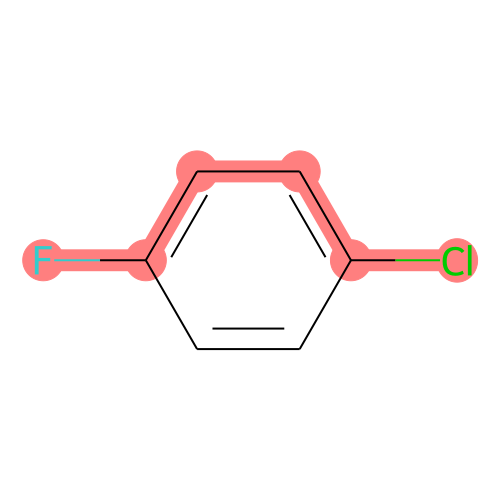

In [ ]:
from rdkit import Chem
from rdkit.Chem import rdBase
from rdkit.Chem import RDConfig
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
from IPython.display import SVG

def hightlightBonds(sml,sub_sml):
  mol = Chem.MolFromSmiles(sml)
  patt = Chem.MolFromSmarts(sub_sml)
  hit_ats = list(mol.GetSubstructMatch(patt))
  hit_bonds = []
  for bond in patt.GetBonds():
    aid1 = hit_ats[bond.GetBeginAtomIdx()]
    aid2 = hit_ats[bond.GetEndAtomIdx()]
    hit_bonds.append(mol.GetBondBetweenAtoms(aid1,aid2).GetIdx())
  return  hit_ats,hit_bonds

a,b = hightlightBonds('c1cc(F)ccc1Cl','ClccccF')
mol = Chem.MolFromSmiles('c1cc(F)ccc1Cl')
d = rdMolDraw2D.MolDraw2DSVG(500, 500) # or MolDraw2DCairo to get PNGs
rdMolDraw2D.PrepareAndDrawMolecule(d, mol, highlightAtoms=a,
                                   highlightBonds=b)
d.FinishDrawing()
text = d.GetDrawingText()
SVG(d.GetDrawingText())

In [ ]:
a

[7, 6, 5, 4, 2, 3]

# Second Way

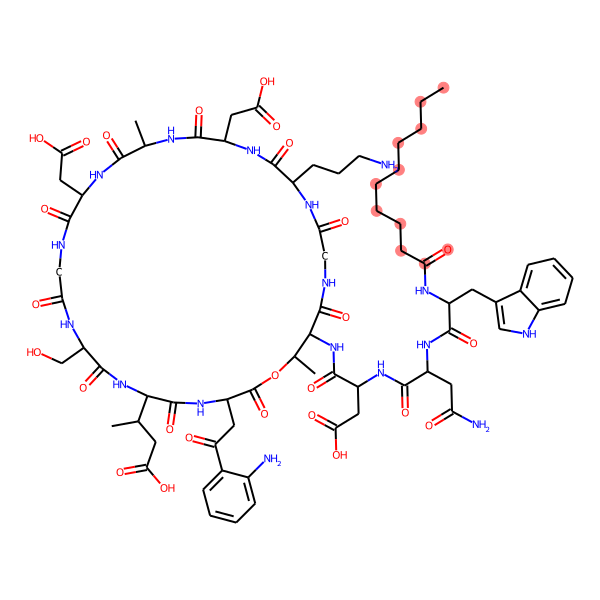

In [ ]:
import rdkit
import rdkit.Chem as Chem
from rdkit.Chem import rdFMCS
from matplotlib import colors
from rdkit.Chem.Draw import MolToImage

def get_mol(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    Chem.Kekulize(mol)
    return mol


def find_matches_one(mol,submol):
    #find all matching atoms for each submol in submol_list in mol.
    match_dict = {}
    mols = [mol,submol] #pairwise search
    res=rdFMCS.FindMCS(mols) #,ringMatchesRingOnly=True)
    mcsp = Chem.MolFromSmarts(res.smartsString)
    matches = mol.GetSubstructMatches(mcsp)
    return matches

#Draw the molecule
def get_image(mol,atomset=None):    
    hcolor = colors.to_rgb('green')
    if atomset is not None:
        #highlight the atoms set while drawing the whole molecule.
        img = MolToImage(mol, size=(600, 600),fitImage=True, highlightAtoms=atomset,highlightColor=hcolor)
    else:
        img = MolToImage(mol, size=(400, 400),fitImage=True)
    return img

peptide_smi = 'CCCCCCCCCC(=O)NC(Cc1c[nH]c2ccccc12)C(=O)NC(CC(N)=O)C(=O)NC(CC(=O)O)C(=O)NC4C(C)OC(=O)C(CC(=O)c3ccccc3(N))NC(=O)C(NC(=O)C(CO)NC(=O)CNC(=O)C(CC(=O)O)NC(=O)C(C)NC(=O)C(CC(=O)O)NC(=O)C(CCCN)NC(=O)CNC4(=O))C(C)CC(=O)O'
monomer_smi = 'CCCCCCCCCC(=O)O'

peptide_mol = get_mol(peptide_smi) #whole molecule
monomer_mol = get_mol(monomer_smi) #substructure molecule

matches = find_matches_one(peptide_mol,monomer_mol)

atomset = list(matches[0])

img = get_image(peptide_mol,atomset)
img 


In [ ]:
mol = Chem.MolFromSmiles('Clc1c(Cl)c(O)ccc1O')
patt = Chem.MolFromSmarts('ClccO')
hit_ats = mol.GetSubstructMatches(patt)
print(hit_ats)
bond_lists = []
for i, hit_at in enumerate(hit_ats):
    hit_at = list(hit_at)
    bond_list = []
    for bond in patt.GetBonds():
        a1 = hit_at[bond.GetBeginAtomIdx()]
        a2 = hit_at[bond.GetEndAtomIdx()]
        bond_list.append(mol.GetBondBetweenAtoms(a1, a2).GetIdx())
    bond_lists.append(bond_list)
print(bond_lists)
colours = [(1, 0, 0), (0, 1, 0), (0, 0, 1)]
atom_cols = {}
bond_cols = {}
atom_list = []
bond_list = []
for i, (hit_atom, hit_bond) in enumerate(zip(hit_ats, bond_lists)):
    hit_atom = list(hit_atom)
    for at in hit_atom:
        atom_cols[at] = colours[i%3]
        atom_list.append(at)
    for bd in hit_bond:
        bond_cols[bd] = colours[i%3]
        bond_list.append(bd)

d = rdMolDraw2D.MolDraw2DCairo(500, 500)
rdMolDraw2D.PrepareAndDrawMolecule(d, mol, highlightAtoms=atom_list,
                                      highlightAtomColors=atom_cols,
                                      highlightBonds=bond_list,
                                      highlightBondColors=bond_cols)
with open('/content/drive/My Drive/Colab Notebooks/GNN_EHS/multi_highlighted_3.png', 'wb') as f:
    f.write(d.GetDrawingText())

((0, 1, 8, 9), (3, 2, 4, 5))
[[0, 9, 8], [2, 3, 4]]


In [ ]:
bond_cols

{0: (1, 0, 0),
 2: (0, 1, 0),
 3: (0, 1, 0),
 4: (0, 1, 0),
 8: (1, 0, 0),
 9: (1, 0, 0)}